## Modelling and evaluation

### Addressing the business question no. 2:
* Can we tell if an uploaded (previously unseen) image was taken for a 'Healthy', 'Bleached' or 'Dead' coral.

### Inputs

* inputs/corals-dataset/Healthy
* inputs/corals-dataset/Bleached
* inputs/corals-dataset/Dead
* outputs/v1/image_shape.pkl

### Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

### Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

### Define working directory

In [8]:
cwd= os.getcwd()
os.chdir('/workspace/corals_health')
print("You set a new current directory")
work_dir = os.getcwd()
work_dir

You set a new current directory


'/workspace/corals_health'

### Set input directories

In [10]:
my_data_dir = 'inputs/corals-dataset/Dataset'
train_path = os.path.join(my_data_dir, 'train')
val_path = os.path.join(my_data_dir, 'validation')
test_path = os.path.join(my_data_dir, 'test')
print(train_path)
print(val_path)
print(test_path)

inputs/corals-dataset/Dataset/train
inputs/corals-dataset/Dataset/validation
inputs/corals-dataset/Dataset/test


### Set output directories

In [11]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set labels

In [13]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)
print(type(labels))

Project Labels: ['Bleached', 'Dead', 'Healthy']
<class 'list'>


### Set image shape

In [14]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(227, 227, 3)

### Number of images in train, test and validation data

* train - Bleached: 503 images
* train - Dead: 105 images
* train - Healthy: 498 images
* validation - Bleached: 72 images
* validation - Dead: 15 images
* validation - Healthy: 71 images
* test - Bleached: 145 images
* test - Dead: 30 images
* test - Healthy: 143 images




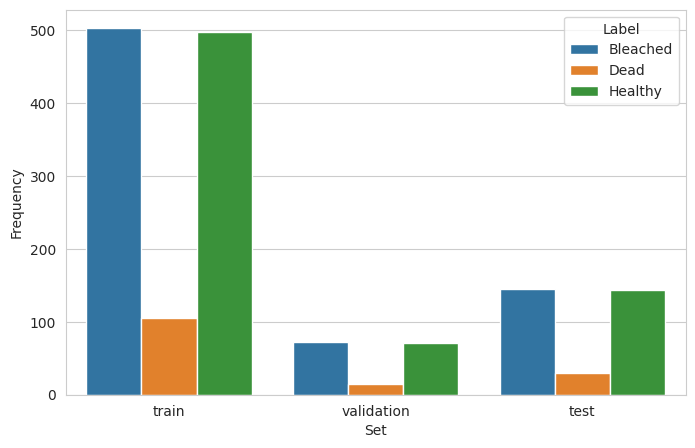

In [15]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Data augmentation

### ImageDataGenerator

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* Initialize ImageDataGenerator

In [17]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

* Augment training dataset

In [18]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 1106 images belonging to 3 classes.


{'Bleached': 0, 'Dead': 1, 'Healthy': 2}

* Augment validation dataset

In [19]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 158 images belonging to 3 classes.


{'Bleached': 0, 'Dead': 1, 'Healthy': 2}

* Aurment test dataset

In [20]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 318 images belonging to 3 classes.


{'Bleached': 0, 'Dead': 1, 'Healthy': 2}

#### Plot augmented training image

(20, 227, 227, 3)


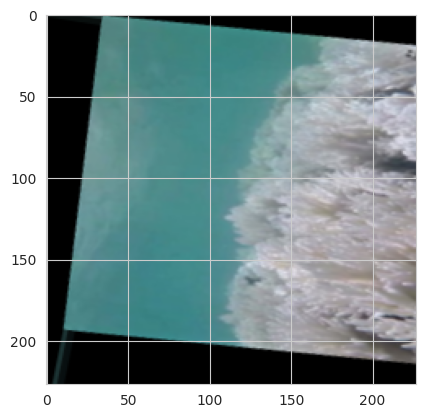

(20, 227, 227, 3)


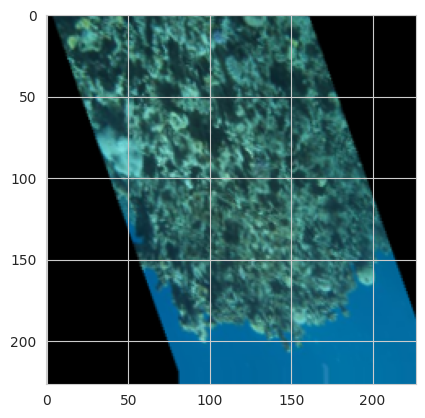

(20, 227, 227, 3)


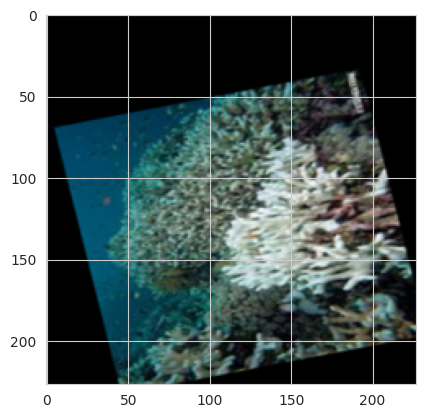

In [24]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

#### Plot augmented validation image

(20, 227, 227, 3)


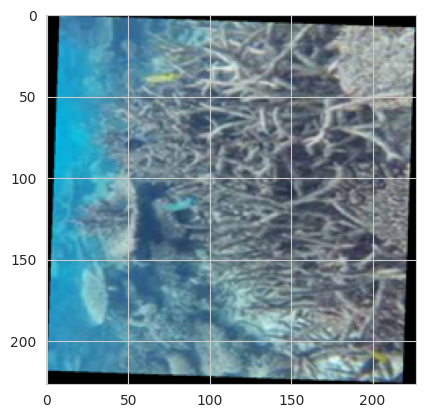

(20, 227, 227, 3)


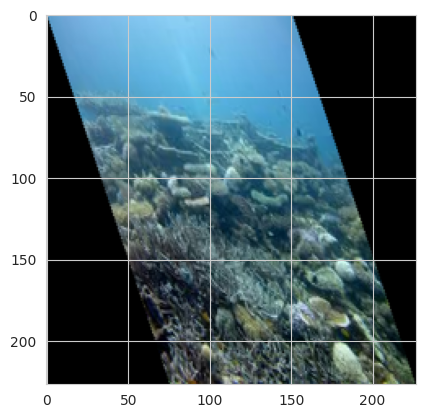

(20, 227, 227, 3)


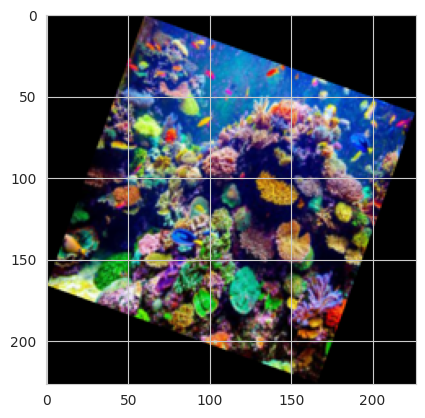

In [25]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

#### Plot augmented test image

(20, 227, 227, 3)


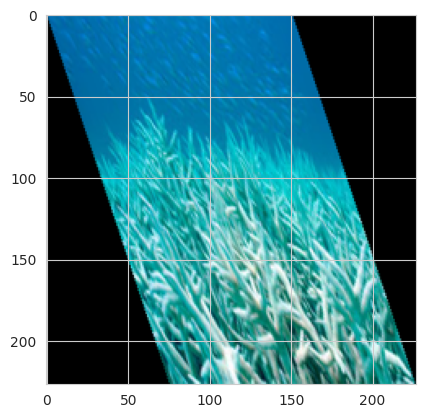

(20, 227, 227, 3)


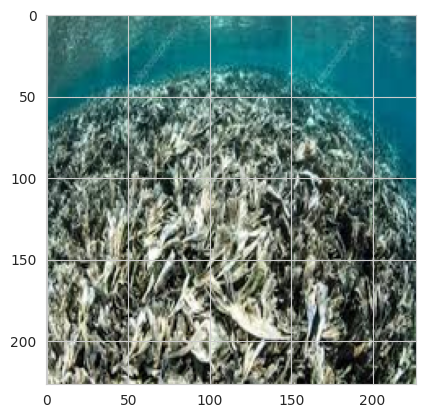

(20, 227, 227, 3)


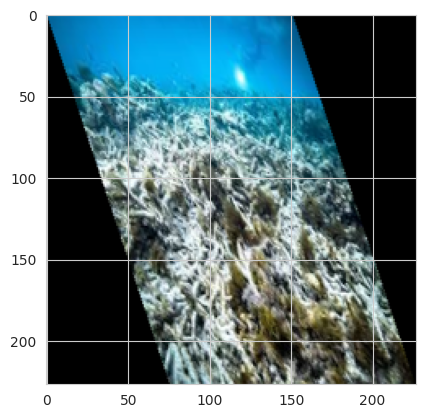

In [26]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

### Save class_indices

In [27]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

<hr>


## Building the model
<hr>